<a href="https://colab.research.google.com/github/stefanbringuier/randomonium/blob/main/notebooks/ASE_Phonopy_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ASE Calculator interface testing with Phonopy
**Stefan Bringuier**

[stefanbringuier@gmail.com](mailto:stefanbringuier@gmail.com)

In [ ]:
! pip install -U ase
! pip install -U seekpath
! pip install -U phonopy

In [ ]:
import matplotlib.pyplot as plt

from ase.atoms import Atoms
from ase.build import bulk
from ase.calculators.emt import EMT
from ase.units import kB
from ase.optimize import FIRE
from ase.constraints import FixAtoms, UnitCellFilter
from ase.spacegroup.symmetrize import FixSymmetry, check_symmetry

from phonopy import Phonopy
from phonopy.structure.atoms import PhonopyAtoms
from phonopy.phonon.band_structure import get_band_qpoints_and_path_connections

In [ ]:
calculator = EMT()

In [ ]:
copper =  bulk('Cu', 'fcc', a=3.6)
copper.set_calculator(calc=calculator)
copper.set_constraint(FixSymmetry(copper))
opt_structure = UnitCellFilter(copper)
opt = FIRE(opt_structure)
opt.run(fmax=1.0e-4)

In [ ]:
structure =  opt_structure.atoms
phnpy_struct = PhonopyAtoms(
    symbols=structure.get_chemical_symbols(),
    positions=structure.get_positions(),
    cell=structure.get_cell(),
    masses=structure.get_masses(),
    )

In [ ]:
def calculate_plot_phonons(d=0.9,n=6):
    phonons = Phonopy(
        phnpy_struct,
        supercell_matrix=[[n, 0, 0],
                          [0, n, 0],
                          [0, 0, n]],
    )
    phonons.generate_displacements(distance=d)
    sets_of_forces = []
    supercells = phonons.get_supercells_with_displacements()

    for d in supercells:
        # Convert back to ASE
        d_ase = Atoms(symbols=d.get_chemical_symbols(),
                      positions=d.get_positions(),
                      cell=d.get_cell(),
                      pbc=True)
        d_ase.set_calculator(calculator)
        forces = d_ase.get_forces()
        sets_of_forces.append(forces)

    phonons.forces = sets_of_forces
    phonons.produce_force_constants()
    phonons.auto_band_structure(npoints=100, plot=True, write_yaml=True)

## Converged Band Structure, displacement=0.9 Ang, supercell = (6,6,6)

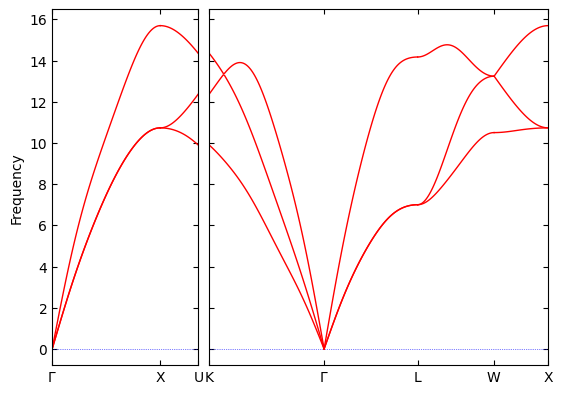

In [ ]:
calculate_plot_phonons()

## Displacement, Supercell Scan

In [ ]:
import ipywidgets as widgets
from IPython.display import display

interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='Displacement:', max=1.0, mi…

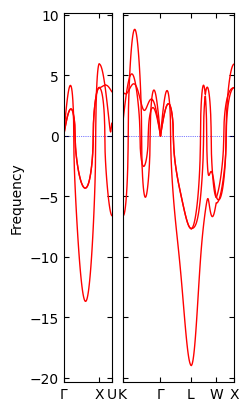

In [ ]:
# Create a slider widget for displacement
displacement_slider = widgets.FloatSlider(
    value=0.1,
    min=0.01,
    max=1.0,
    step=0.25,
    description='Displacement:',
    continuous_update=False
)
supercell_slider = widgets.IntSlider(
    value=6,
    min=2,
    max=10,
    step=1,
    description='n x n x n:',
    continuous_update=False
)
# Display the widget and output
widgets.interactive(calculate_plot_phonons,
                    d=displacement_slider,
                    n=supercell_slider)